In [12]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy.stats import binom_test
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
from matplotlib.markers import TICKDOWN
import matplotlib
import datetime
from scipy.stats import norm
import imageio
from matplotlib.gridspec import GridSpec

from lib.analysis.laminar_dist import Line

In [13]:
# intralaminar PV velocities over barrels of size 100-300 um
barrel_latency_PV = 200 / 57  # ms
barrel_latency_PV_se = 100 / 41
# Katherine S Scheuer, John M Judge, Xinyu Zhao, Meyer B Jackson, Velocity of conduction between columns and layers in barrel cortex reported by parvalbumin interneurons, Cerebral Cortex 33:17, 1 Sept 2023, p 9917–9926
print(barrel_latency_PV, barrel_latency_PV_se)

3.508771929824561 2.4390243902439024


In [14]:
barrel_latency_PV_excitatory_L4 = 1.028032
barrel_latency_PV_excitatory_L4_se = 1.0011922707332492

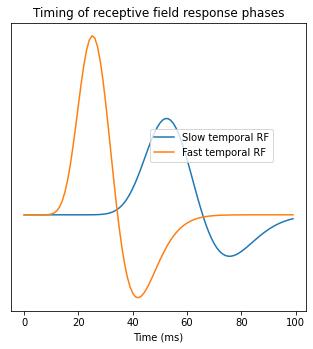

In [24]:
# from http://www.georgemather.com/Model.html#Refs

# Define the space axis of the filters
nx = 80  # Number of spatial samples in the filter
max_x = 2.0  # Half-width of filter (deg)
dx = (max_x * 2) / nx  # Spatial sampling interval of filter (deg)

# A row vector holding spatial sampling intervals
x_filt = np.linspace(-max_x, max_x, nx)

# Spatial filter parameters
sx = 0.5 # standard deviation of Gaussian, in deg.
sf = 1.1 # spatial frequency of carrier, in cpd

# Spatial filter response
gauss = np.exp(-x_filt ** 2 / sx ** 2)  # Gaussian envelope
even_x = np.cos(2 * np.pi * sf * x_filt) * gauss  # Even Gabor
odd_x = np.sin(2 * np.pi * sf * x_filt) * gauss  # Odd Gabor

# Define the time axis of the filters
nt = 100  # number temporal samples in the filter
max_t = 0.5  # Duration of impulse response (sec)
dt = max_t / nt  #Temporal sampling interval (sec)

# temporal sampling intervals
t_filt = np.linspace(0, max_t, nt)

# Temporal filter parameters
k = 100 # Scales the response into time units
slow_n = 30 # Width of the slow temporal filter
fast_n = 15 # Width of the fast temporal filter
beta = 0.9 # Weighting of  -ve phase of the temporal resp relative to +ve phase.

# Temporal filter response
slow_t = (k * t_filt) ** slow_n * np.exp(-k * t_filt) * (1 / np.math.factorial(slow_n) - beta * ((k * t_filt) ** 2) / np.math.factorial(slow_n + 2))
fast_t = (k * t_filt) ** fast_n * np.exp(-k * t_filt) * (1 / np.math.factorial(fast_n) - beta * ((k * t_filt) ** 2) / np.math.factorial(fast_n + 2))

plt.plot(slow_t, label="Slow temporal RF")
plt.plot(fast_t, label="Fast temporal RF")
plt.xlabel("Time (ms)")
plt.title("Timing of receptive field response phases")
plt.yticks([])
plt.legend(bbox_to_anchor=(0.68, 0.65), loc='upper center')
#plt.annotate("EPSPs", xy=(5.08, 0.2))
#plt.annotate("IPSPs", xy=(10.08, -0.01))
ax = plt.gca()
# ax.set_xlim([0, 40])

In [16]:
# spatiotemporal filters (matrices)
e_slow = slow_t.reshape(-1, 1) @ np.transpose(even_x).reshape(1, -1)  # SE/TS
e_fast = fast_t.reshape(-1, 1) @ np.transpose(even_x).reshape(1, -1)   # SE/TF
o_slow = slow_t.reshape(-1, 1) @ np.transpose(odd_x).reshape(1, -1)   # SO/TS
o_fast = fast_t.reshape(-1, 1) @ np.transpose(odd_x).reshape(1, -1)   # SO/TF

# Spatiotemporally oriented filters
left_1 = o_fast + e_slow  # L1
left_2 = -o_slow + e_fast  # L2
right_1 = -o_fast + e_slow  # R1
right_2 = o_slow + e_fast  # R2

#for im in [left_1, left_2, right_1, right_2]:
#    plt.imshow(im)
#    ax = plt.gca()
#    ax.set_xlim([20, 60])
#    ax.set_ylim([0, 20])
#    plt.show()

Text(0.5, 0, 'Temporal axis (ms)')

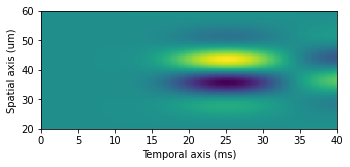

In [18]:
# visualize filters
matplotlib.rc ('figure', figsize= (5.3, 5.3))
plt.imshow(np.transpose(left_1).astype(np.float32))
ax = plt.gca()
ax.set_xlim([0, 40])
ax.set_ylim([20, 60])
ax.set_aspect(2/5)
plt.ylabel("Spatial axis (um)")
plt.xlabel("Temporal axis (ms)")
# plt.imshow(left_1)

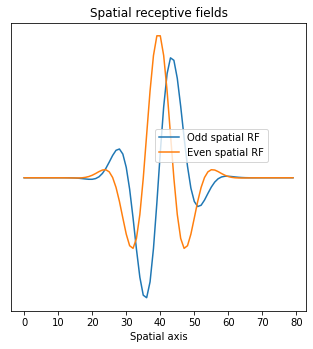

In [25]:
plt.plot(odd_x, label="Odd spatial RF")
plt.plot(even_x, label="Even spatial RF")
plt.xlabel("Spatial axis")
plt.title("Spatial receptive fields")
plt.yticks([])
plt.legend(bbox_to_anchor=(0.68, 0.65), loc='upper center')
plt.show()

In [ ]:
stim_width=4  # half width in degrees, gives 8 degrees total
stim_dur=1.5  # total duration of the stimulus in seconds

In [ ]:
stim = np.genfromtxt('M_tab.txt', dtype=None, delimiter='\t')

# Rightward responses to stim
resp_right_1 = convolve(stim, right_1)
resp_right_2 = convolve(stim, right_2)

# Leftward responses
resp_left_1 = convolve(stim, left_1)
resp_left_2 = convolve(stim, left_2)

In [ ]:
# square and normalize
resp_left_1 = resp_left_1 ** 2
resp_left_2 = resp_left_2  ** 2
resp_right_1 = resp_right_1 ** 2
resp_right_2 = resp_right_2 ** 2

# Calc left and right energy
energy_right = resp_right_1 + resp_right_2
energy_left = resp_left_1 + resp_left_2

# Calc total energy
total_energy = sum(sum(energy_right))+sum(sum(energy_left))

# Normalise
RR1 = sum(sum(resp_right_1)) / total_energy
RR2 = sum(sum(resp_right_2)) / total_energy
LR1 = sum(sum(resp_left_1)) / total_energy
LR2 = sum(sum(resp_left_2)) / total_energy

# directional energy
right_Total = RR1 + RR2
left_Total = LR1 + LR2

# net motion energy
motion_energy = right_Total - left_Total;
print('Net motion energy =', motion_energy)

In [ ]:
# Generate motion contrast matrix
energy_opponent = energy_right - energy_left  # L-R difference matrix
energy_flicker = total_energy / (energy_left.shape[0] * energy_left.shape[1])  # A value for average total energy

# Re-scale L-R matrix using average energy.
motion_contrast = energy_opponent / energy_flicker
plt.imshow(np.transpose(stim))
plt.title("Example Stimulus")
plt.ylabel("Spatial axis (um)")
plt.xticks([])
plt.show()
plt.imshow(np.transpose(motion_contrast))
plt.title("Energy motion response")
plt.ylabel("Spatial axis (um)")
plt.xlabel("Time axis (ms)")